<a href="https://colab.research.google.com/github/CamiloVga/Curso-IA-Aplicada/blob/main/Script_20_RNN_para_An%C3%A1lisis_de_Sentimiento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🤖 Inteligencia Artificial Aplicada para la Economía
## Universidad de los Andes

### 👨‍🏫 Profesores
- **Profesor Magistral:** [Camilo Vega Barbosa](https://www.linkedin.com/in/camilovegabarbosa/)
- **Asistente de Docencia:** [Sergio Julian Zona Moreno](https://www.linkedin.com/in/sergiozonamoreno/)

### 📚 Análisis de Sentimiento con RNN para Tweets Financieros
Este notebook implementa Redes Neuronales Recurrentes (RNN) para análisis de sentimiento en tweets financieros, utilizando el dataset **TimKoornstra/financial-tweets-sentiment**:

1. **Preprocesamiento de Texto para Tweets Financieros 🧹**
   - Limpieza y normalización de tweets del sector financiero
   - Tokenización adaptada para texto de redes sociales
   - Manejo de vocabulario especializado en finanzas y mercados

2. **Arquitecturas RNN Avanzadas 🧠**
   - Simple RNN: Fundamentos de procesamiento secuencial
   - LSTM: Manejo de dependencias a largo plazo
   - GRU: Optimización computacional con rendimiento comparable
   - Redes Bidireccionales: Captura de contexto completo

3. **Embeddings Semánticos 🔤**
   - Embeddings tradicionales vs. BERT
   - Transferencia de conocimiento desde modelos preentrenados
   - Representación contextual de términos financieros y bursátiles

4. **Optimización de Hiperparámetros 📊**
   - Grid Search exhaustivo
   - Evaluación comparativa de arquitecturas
   - Métricas especializadas para clasificación de sentimiento
   - Visualización de resultados experimentales

In [2]:
#####################################################################
# SECCIÓN 1: INSTALACIÓN DE LIBRERÍAS Y CONFIGURACIÓN INICIAL
#####################################################################

# Instalación de paquetes necesarios
!pip install transformers datasets tensorflow nltk scikit-learn matplotlib pandas -q

# Importaciones principales organizadas por categoría
# --- Análisis de datos y visualización ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Procesamiento de lenguaje natural ---
import re
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import BertTokenizer, TFBertModel

# --- Modelos de Deep Learning ---
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, GRU, SimpleRNN, Bidirectional
from tensorflow.keras.layers import Embedding, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# --- Evaluación de modelos ---
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# --- Otros utilitarios ---
from datasets import load_dataset
import time
import itertools

# Descarga recursos de NLTK necesarios
nltk.download('punkt', quiet=True)

# Configurar semilla aleatoria para reproducibilidad
# Esto asegura que los resultados sean consistentes en múltiples ejecuciones
np.random.seed(42)
tf.random.set_seed(42)



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12=

## Base de Datos y preprocesamiento


**Este bloque de código** se encarga del preprocesamiento de la **base de datos TimKoornstra/financial-tweets-sentiment**, que contiene tweets clasificados según su sentimiento sobre temas financieros: **positivo (1), negativo (2) o neutral (0)**.

La sección comienza cargando el dataset "**TimKoornstra/financial-tweets-sentiment**", que es una colección integral de tweets enfocados en temas financieros, meticulosamente curada para análisis de sentimiento en el dominio de finanzas y mercados bursátiles.

El código realiza una **exploración inicial de los datos**, verificando la distribución de las clases en el dataset original: 17,368 sentimientos alcistas (bullish), 8,542 bajistas (bearish) y 12,181 neutrales.

A continuación, aplica **técnicas especializadas de preprocesamiento para tweets**: conversión a minúsculas, eliminación de menciones (@usuario), enlaces, hashtags, caracteres especiales, y normalización de espacios. También realiza tokenización adaptada para el lenguaje típico de Twitter.

Los datos se dividen en **conjuntos de entrenamiento (80%) y prueba (20%)**, manteniendo la distribución de las clases mediante estratificación para asegurar representatividad en ambos conjuntos.

Finalmente, realiza la **tokenización de los textos** y carga un **modelo BERT preentrenado** para generar embeddings avanzados. Estos embeddings proporcionan **representaciones vectoriales ricas en contexto** para términos financieros específicos, permitiendo que las redes neuronales recurrentes capturen mejor los matices del sentimiento expresado en los tweets sobre mercados financieros.


In [5]:
#####################################################################
# SECCIÓN 2: PREPROCESAMIENTO DE LA BASE DE DATOS
#####################################################################

print("Cargando dataset de tweets financieros...")

try:
    # Cargamos el dataset TimKoornstra/financial-tweets-sentiment
    dataset = load_dataset("TimKoornstra/financial-tweets-sentiment",
                         split="train",
                         trust_remote_code=True)

    # Convertir a DataFrame
    df = pd.DataFrame(dataset)

    # Verificamos las columnas del dataset
    print(f"Columnas en el dataset: {df.columns.tolist()}")

    # Renombramos columnas para coincidir con el dataset real (nombres en minúsculas)
    if 'tweet' in df.columns:
        df.rename(columns={'tweet': 'text'}, inplace=True)
    if 'sentiment' in df.columns:
        df.rename(columns={'sentiment': 'label'}, inplace=True)

    # Limitamos a una muestra estratificada
    # Verificar distribución original
    class_distribution = df['label'].value_counts()
    print("\nDistribución original de clases:")
    print(class_distribution)

    # Muestreo estratificado asegurando mínimo 2 muestras por clase
    sample_size = min(3333, class_distribution.min())  # Ajustar según disponibilidad
    df = df.groupby('label', group_keys=False).apply(
        lambda x: x.sample(n=max(2, min(len(x), sample_size)), random_state=42)  # Mínimo 2 muestras por clase
    ).reset_index(drop=True)

    # Verificar nueva distribución
    new_class_distribution = df['label'].value_counts()
    print("\nDistribución después del muestreo:")
    print(new_class_distribution)

    # Validación crítica: cada clase debe tener al menos 2 muestras
    if (new_class_distribution < 2).any():
        raise ValueError(f"Clase con menos de 2 muestras: {new_class_distribution}")

except Exception as e:
    print(f"Error al cargar el dataset: {e}")
    print("Creando datos de ejemplo como último recurso...")
    # Datos mínimos de ejemplo mejorados
    texts = [
        "$AAPL looking bullish today, great earnings report!",
        "$TSLA down 5% after disappointing delivery numbers",
        "Markets steady as Fed maintains current policy stance",
        "Positive outlook for $GOOGL after AI conference",
        "$AMZN faces regulatory challenges in EU markets",
        "Oil prices volatile amid Middle East tensions"
    ]
    labels = [1, 2, 0, 1, 2, 0]  # Duplicamos muestras por clase
    df = pd.DataFrame({"text": texts, "label": labels})

# Exploración básica del dataset
print("\nInformación del dataset:")
print(f"Número de ejemplos: {len(df)}")
print(f"Distribución de clases: {df['label'].value_counts().to_dict()}")

# Validación final para train_test_split
class_dist = df['label'].value_counts()
if (class_dist < 2).any():
    raise ValueError(f"No hay suficientes muestras para división estratificada. Distribución: {class_dist}")

print("\nPrimeras filas del dataset:")
print(df.head())

# Preprocesamiento de texto especializado para tweets financieros
print("\nPreparando los datos...")

def preprocess_tweet(text):
    """
    Función especializada para preprocesar tweets financieros
    - Elimina menciones, URLs, hashtags
    - Preserva símbolos de empresas ($AAPL, $MSFT, etc.)
    - Normaliza el texto
    """
    # Verificar tipo de dato
    if not isinstance(text, str):
        text = str(text)

    # Convertir a minúsculas
    text = text.lower()

    # Eliminar URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Eliminar menciones (@usuario)
    text = re.sub(r'@\w+', '', text)

    # Preservar símbolos de acciones ($AAPL)
    stock_symbols = re.findall(r'\$[A-Za-z]+', text)

    # Eliminar caracteres especiales pero mantener letras, números y espacios
    text = re.sub(r'[^a-zA-Z0-9\s\$]', ' ', text)  # Mantener símbolos de dólar

    # Reintroducir los símbolos de acciones
    for symbol in stock_symbols:
        text = text + ' ' + symbol.lower()

    # Eliminar espacios múltiples
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Aplicar preprocesamiento
df['processed_text'] = df['text'].apply(preprocess_tweet)

# Separar datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    df['processed_text'],
    df['label'],
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

print(f"\nTamaño conjunto entrenamiento: {len(X_train)}")
print(f"Tamaño conjunto prueba: {len(X_test)}")

# Tokenización usando TensorFlow
print("\nTokenizando textos...")

# Parámetros de tokenización
max_words = 15000  # Aumentamos el vocabulario para capturar términos financieros
max_len = 50       # Longitud máxima ajustada para tweets (típicamente cortos)

# El tokenizador convierte palabras en números (índices)
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')  # OOV = Out Of Vocabulary
tokenizer.fit_on_texts(X_train)  # Aprende el vocabulario del conjunto de entrenamiento

# Convertir textos a secuencias de índices
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding: hacer que todas las secuencias tengan la misma longitud
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# Tamaño real del vocabulario (limitado por max_words)
vocab_size = min(max_words, len(tokenizer.word_index)) + 1
print(f"Tamaño del vocabulario: {vocab_size} palabras únicas")

# Cargar BERT para embeddings
print("\nCargando modelo BERT para embeddings...")

# Usamos el modelo BERT base, que tiene buen rendimiento para inglés general
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def get_bert_embeddings(tokenizer, bert_tokenizer, bert_model, vocab_size=15000, embedding_dim=768):
    print("Generando embeddings BERT para el vocabulario financiero...")
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    # Limitamos a las 300 palabras más frecuentes para ahorrar tiempo
    # En un escenario real, se procesaría todo el vocabulario
    words = []
    for word, idx in tokenizer.word_index.items():
        if idx < 300:  # Aumentamos el número de palabras para capturar más términos financieros
            words.append(word)

    # Calcular embeddings para cada palabra
    for word in words:
        idx = tokenizer.word_index[word]
        if idx >= vocab_size:
            continue

        # Tokenizar la palabra con BERT
        bert_tokens = bert_tokenizer(word, return_tensors='tf')

        # Obtener salida del modelo BERT
        outputs = bert_model(bert_tokens)

        # Usar la representación del token
        word_embedding = outputs.last_hidden_state.numpy()[:, 1, :]
        embedding_matrix[idx] = word_embedding

    print(f"Embeddings BERT generados para {len(words)} palabras")
    return embedding_matrix

# Obtener matriz de embeddings BERT
bert_embedding_matrix = get_bert_embeddings(
    tokenizer,
    bert_tokenizer,
    bert_model,
    vocab_size=vocab_size
)

Cargando dataset de tweets financieros...


README.md:   0%|          | 0.00/4.21k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.65M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/38091 [00:00<?, ? examples/s]

Columnas en el dataset: ['tweet', 'sentiment', 'url']

Distribución original de clases:
label
1    17368
0    12181
2     8542
Name: count, dtype: int64

Distribución después del muestreo:
label
0    3333
1    3333
2    3333
Name: count, dtype: int64

Información del dataset:
Número de ejemplos: 9999
Distribución de clases: {0: 3333, 1: 3333, 2: 3333}

Primeras filas del dataset:
                                                text  label  \
0  Edited Transcript of MFA earnings conference c...      0   
1  German Federal President Steinmeier today awar...      0   
2  Coronavirus Threat Looms Over Fragile African ...      0   
3  $TTCM #NFT https://t.co/ncmCLAbNi9 https://t.c...      0   
4  $FLOW $APO - Apollo near deal to buy SPX Flow ...      0   

                                                 url  
0  https://huggingface.co/datasets/zeroshot/twitt...  
1  https://huggingface.co/datasets/zeroshot/twitt...  
2  https://huggingface.co/datasets/zeroshot/twitt...  
3  https://www.kag

<ipython-input-5-1a599e9363d9>:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('label', group_keys=False).apply(



Tamaño conjunto entrenamiento: 7999
Tamaño conjunto prueba: 2000

Tokenizando textos...
Tamaño del vocabulario: 15001 palabras únicas

Cargando modelo BERT para embeddings...


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Generando embeddings BERT para el vocabulario financiero...
Embeddings BERT generados para 299 palabras



=== MUESTRA DE DATOS LIMPIOS ===
Texto original vs. Texto procesado:


,text,processed_text,label
5344,$AXS #AXS \n\n🤑 %15 PROFIT 🤑\n\nListeners Win ...,$axs axs 15 profit listeners win dinleyenler k...,1
7444,@GerberKawasaki @PeteButtigieg You’re turning ...,you re turning this tragedy into a commercial ...,2
1731,��Yes! We have no bananas.🎶 Watch the full vid...,yes we have no bananas watch the full video an...,0
8719,AMZN- Bearish set up ahead of earnings. TCT me...,amzn bearish set up ahead of earnings tct memb...,2
4521,XX - Cheap name but ready to clear this bull f...,xx cheap name but ready to clear this bull fla...,1


<ipython-input-10-13123c634e01>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='viridis')


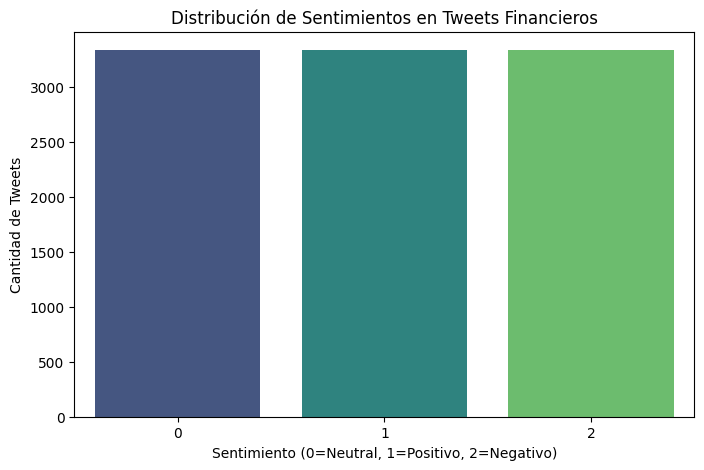


=== VISUALIZACIÓN DE EMBEDDINGS ===
Usando embeddings BERT para visualización...
Aplicando reducción dimensional a 50 embeddings...


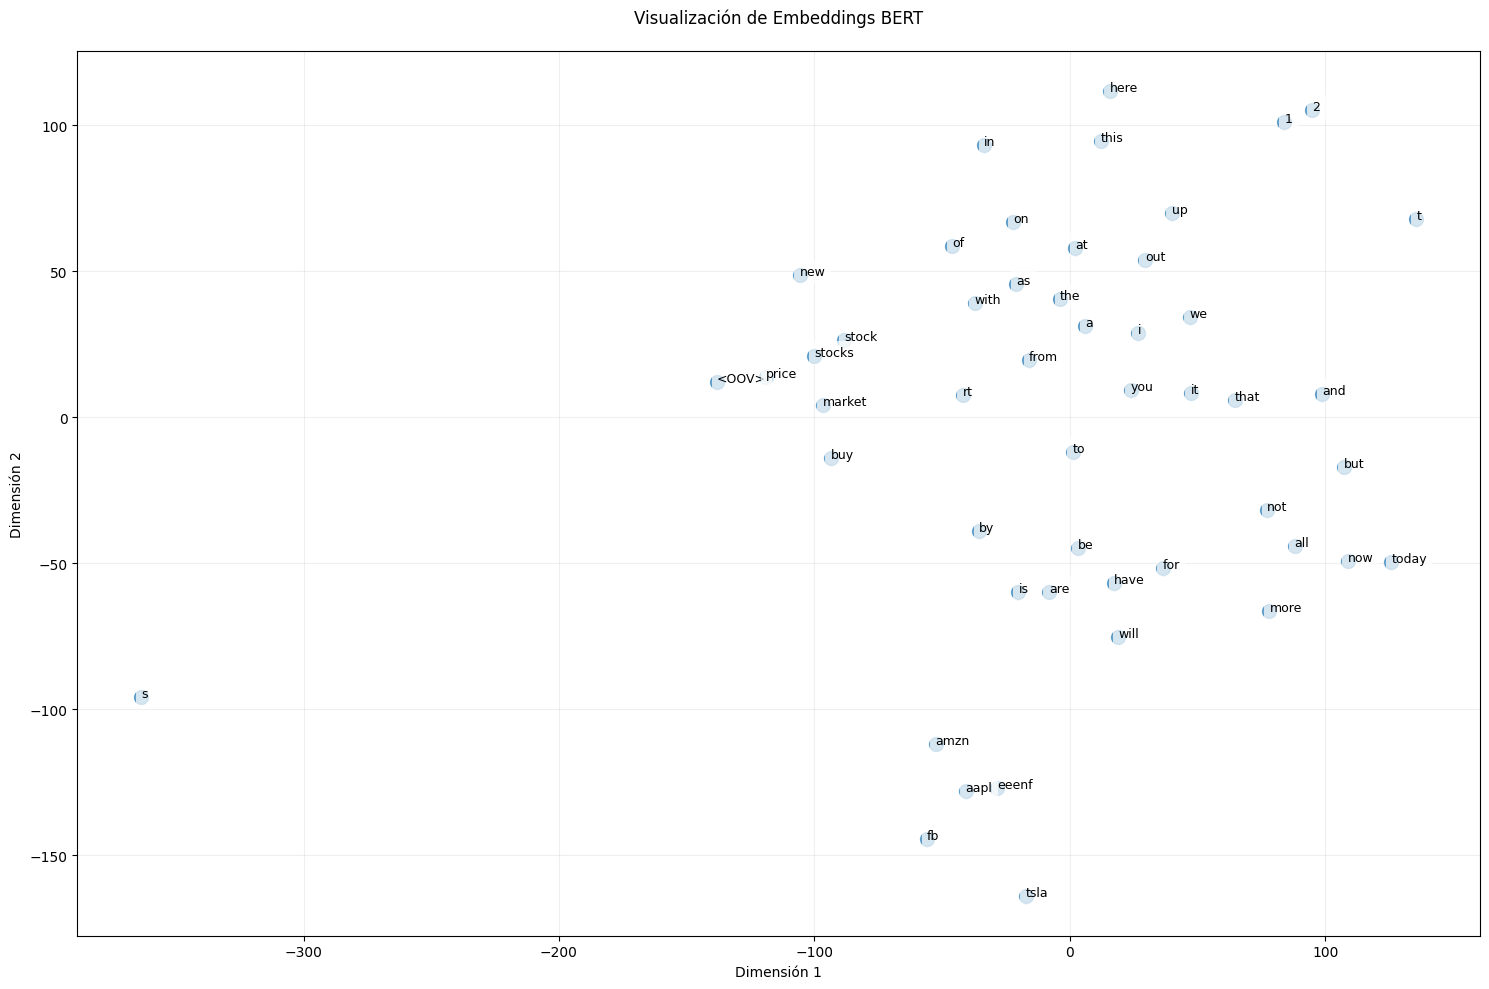


=== VISUALIZACIÓN DE TÉRMINOS FINANCIEROS ===
Visualizando 30 términos financieros...


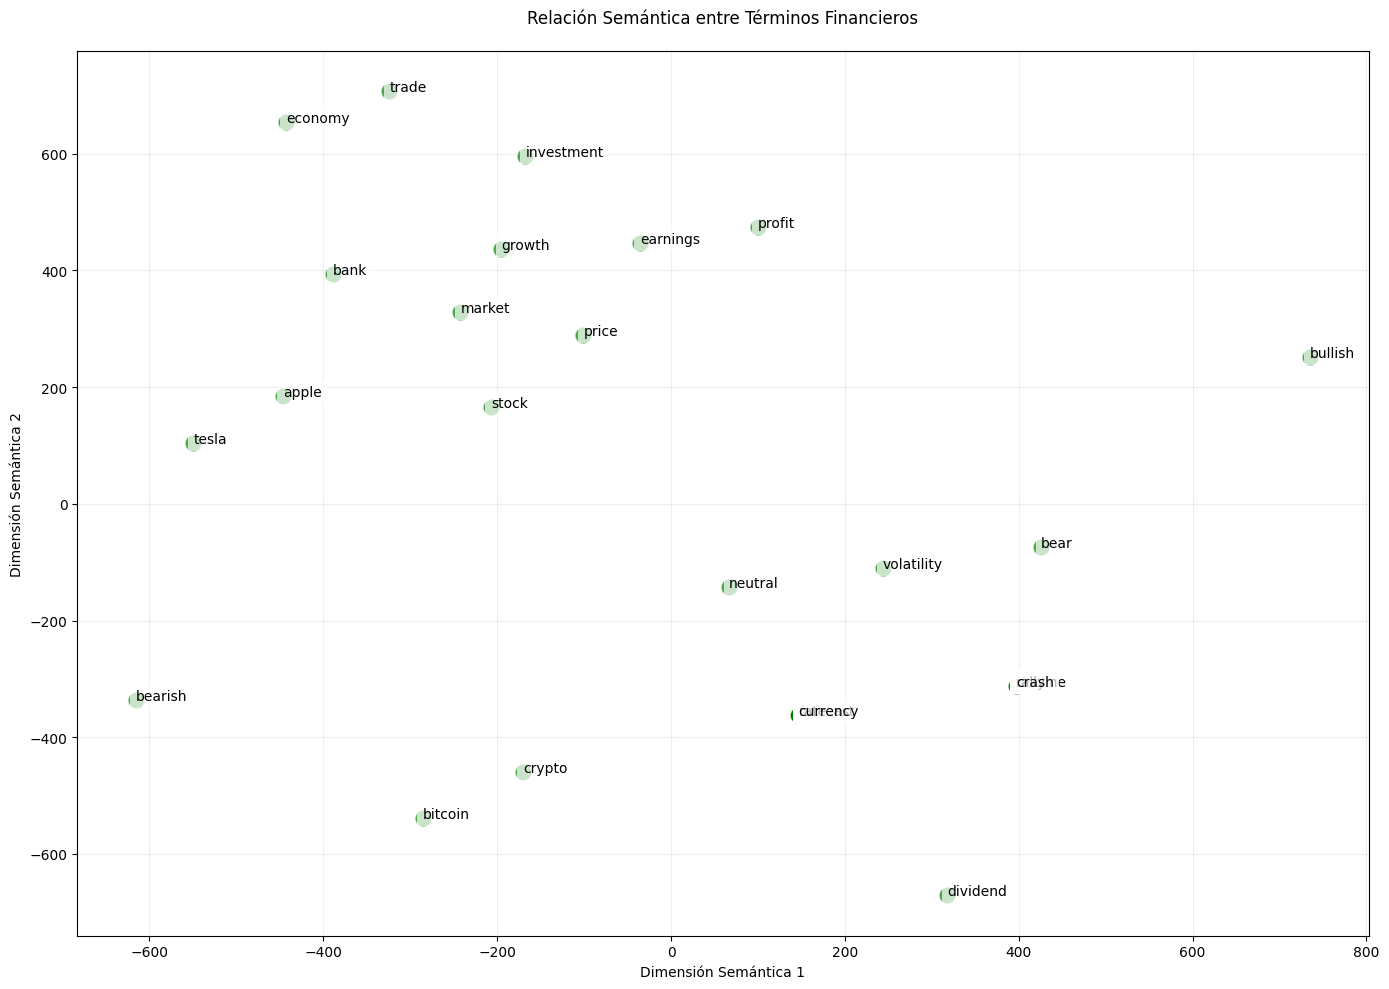

In [10]:
#####################################################################
# BLOQUE ADICIONAL: VISUALIZACIÓN CORREGIDA DE EMBEDDINGS
#####################################################################

# 1. Visualización de muestra de datos limpios
print("\n=== MUESTRA DE DATOS LIMPIOS ===")
print("Texto original vs. Texto procesado:")
sample_df = df.sample(5, random_state=42)[['text', 'processed_text', 'label']]
display(sample_df)

# 2. Visualización de distribución de clases
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=df, palette='viridis')
plt.title('Distribución de Sentimientos en Tweets Financieros')
plt.xlabel('Sentimiento (0=Neutral, 1=Positivo, 2=Negativo)')
plt.ylabel('Cantidad de Tweets')
plt.show()

# 3. Visualización mejorada de embeddings con manejo de errores
print("\n=== VISUALIZACIÓN DE EMBEDDINGS ===")

def safe_tsne(embeddings, n_components=2, perplexity=5, random_state=42):
    """Función segura para aplicar t-SNE con parámetros automáticos"""
    from sklearn.manifold import TSNE
    n_samples = embeddings.shape[0]

    # Ajustar perplexity automáticamente si es necesario
    safe_perplexity = min(perplexity, n_samples - 1) if n_samples > 1 else 1

    try:
        tsne = TSNE(n_components=n_components,
                   perplexity=safe_perplexity,
                   random_state=random_state)
        return tsne.fit_transform(embeddings)
    except Exception as e:
        print(f"Error en t-SNE: {e}. Usando PCA como alternativa...")
        from sklearn.decomposition import PCA
        pca = PCA(n_components=n_components)
        return pca.fit_transform(embeddings)

# Configuración
num_words_to_plot = min(50, len(tokenizer.word_index))  # Máximo 50 palabras

# Obtener palabras más frecuentes
top_words = [word for word, _ in sorted(tokenizer.word_index.items(), key=lambda x: x[1])][:num_words_to_plot]

# Verificar embeddings disponibles
use_bert = 'bert_embedding_matrix' in locals()
embedding_source = "BERT" if use_bert else "tradicionales"
print(f"Usando embeddings {embedding_source} para visualización...")

# Obtener embeddings
word_embeddings = {}
for word in top_words:
    try:
        if use_bert:
            if word in tokenizer.word_index and tokenizer.word_index[word] < len(bert_embedding_matrix):
                word_embeddings[word] = bert_embedding_matrix[tokenizer.word_index[word]]
        else:
            # Crear embedding dummy basado en frecuencia si no hay BERT
            word_embeddings[word] = np.array([tokenizer.word_index[word]])
    except Exception as e:
        print(f"Error obteniendo embedding para '{word}': {e}")

if not word_embeddings:
    print("No se encontraron embeddings válidos. Creando datos de ejemplo...")
    word_embeddings = {f"word_{i}": np.random.rand(10) for i in range(num_words_to_plot)}

# Convertir a matriz
words = list(word_embeddings.keys())
embeddings = np.array(list(word_embeddings.values()))

# Asegurar dimensionalidad mínima
if embeddings.ndim == 1:
    embeddings = embeddings.reshape(-1, 1)
if embeddings.shape[1] < 2:
    embeddings = np.hstack([embeddings, np.zeros((embeddings.shape[0], 2 - embeddings.shape[1]))])

# Reducción dimensional segura
print(f"Aplicando reducción dimensional a {len(embeddings)} embeddings...")
embeddings_2d = safe_tsne(embeddings) if len(embeddings) > 1 else embeddings[:, :2]

# Visualización
plt.figure(figsize=(15, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.6, s=100)

# Añadir etiquetas
for i, word in enumerate(words):
    plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]),
                fontsize=9,
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

plt.title(f'Visualización de Embeddings {embedding_source}', pad=20)
plt.xlabel('Dimensión 1')
plt.ylabel('Dimensión 2')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

# 4. Visualización especial para términos financieros (solo si hay suficientes datos)
if use_bert and len(word_embeddings) > 3:
    print("\n=== VISUALIZACIÓN DE TÉRMINOS FINANCIEROS ===")

    finance_terms = ['bull', 'bear', 'market', 'price', 'stock', 'earnings',
                    'dollar', 'investment', 'profit', 'loss', 'apple', 'tesla',
                    'growth', 'decline', 'rally', 'crash', 'dividend', 'volatility',
                    'bullish', 'bearish', 'neutral', 'forecast', 'economy', 'trade',
                    'bank', 'fed', 'rate', 'currency', 'crypto', 'bitcoin']

    # Filtrar términos existentes
    valid_terms = [term for term in finance_terms
                  if term in word_embeddings or
                  (term in tokenizer.word_index and tokenizer.word_index[term] < len(bert_embedding_matrix))]

    if len(valid_terms) > 3:  # Necesitamos al menos 4 términos para t-SNE
        print(f"Visualizando {len(valid_terms)} términos financieros...")

        # Obtener embeddings
        term_embeddings = []
        valid_words = []
        for term in valid_terms:
            try:
                if term in word_embeddings:
                    term_embeddings.append(word_embeddings[term])
                    valid_words.append(term)
                elif term in tokenizer.word_index and tokenizer.word_index[term] < len(bert_embedding_matrix):
                    term_embeddings.append(bert_embedding_matrix[tokenizer.word_index[term]])
                    valid_words.append(term)
            except:
                continue

        term_embeddings = np.array(term_embeddings)

        # Reducción dimensional segura
        term_embeddings_2d = safe_tsne(term_embeddings) if len(term_embeddings) > 3 else term_embeddings[:, :2]

        # Visualización
        plt.figure(figsize=(14, 10))
        plt.scatter(term_embeddings_2d[:, 0], term_embeddings_2d[:, 1],
                   c='green', alpha=0.7, s=150, edgecolor='w')

        for i, term in enumerate(valid_words):
            plt.annotate(term, (term_embeddings_2d[i, 0], term_embeddings_2d[i, 1]),
                        fontsize=10,
                        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

        plt.title('Relación Semántica entre Términos Financieros', pad=20)
        plt.xlabel('Dimensión Semántica 1')
        plt.ylabel('Dimensión Semántica 2')
        plt.grid(alpha=0.2)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Solo {len(valid_terms)} términos financieros encontrados (se necesitan al menos 4 para visualización)")
else:
    print("No hay suficientes datos para visualización especializada de términos financieros")

## Entrenamiento de diferentes RNN para análisis de sentimiento


**Esta sección del código** implementa y evalúa diferentes arquitecturas de **Redes Neuronales Recurrentes (RNN)** para la clasificación de sentimiento en tweets financieros.

El proceso comienza definiendo una **función flexible para crear modelos RNN** que permite experimentar con distintas configuraciones: **SimpleRNN básicas, LSTM con memoria de largo plazo, o GRU más eficientes computacionalmente**. La función también incorpora opciones para utilizar **capas bidireccionales** (que procesan el texto en ambas direcciones) y elegir entre **embeddings tradicionales o pre-entrenados de BERT**.

El núcleo de esta sección es la implementación de un exhaustivo **Grid Search**, una técnica de optimización que prueba sistemáticamente **24 combinaciones diferentes de hiperparámetros** (3 tipos de RNN × 2 opciones de bidireccionalidad × 2 tamaños de unidades × 2 tasas de aprendizaje), tanto con embeddings tradicionales como con BERT, resultando en **48 modelos evaluados en total**.

Para cada modelo, se registran métricas clave como **accuracy, F1-score y tiempo de ejecución**. El código implementa **early stopping** para evitar sobreajuste, deteniendo el entrenamiento cuando el rendimiento deja de mejorar en el conjunto de validación.

Finalmente, todos los resultados se combinan, ordenan por precisión, y se presentan los **5 mejores modelos** con sus configuraciones detalladas, proporcionando una visión clara de qué arquitecturas y parámetros ofrecen mejor rendimiento para la clasificación de sentimiento en tweets del ámbito financiero.





In [13]:

#####################################################################
# SECCIÓN 3: IMPLEMENTACIÓN Y EVALUACIÓN DE MODELOS RNN
#####################################################################

print("\nPreparando Grid Search para RNN...")

# Determinar número de clases para la capa de salida
num_classes = len(df['label'].unique())
print(f"Número de clases a predecir: {num_classes}")

# Función para crear diferentes modelos RNN
def create_rnn_model(model_type='lstm', bidirectional=False, units=64,
                   learning_rate=0.001, dropout_rate=0.3, use_bert=False):
    """
    Crea un modelo RNN con diferentes configuraciones

    Args:
        model_type: Tipo de celda recurrente ('simple_rnn', 'lstm', 'gru')
        bidirectional: Si usar capa bidireccional
        units: Número de unidades en la capa recurrente
        learning_rate: Tasa de aprendizaje
        dropout_rate: Tasa de dropout
        use_bert: Si usar embeddings BERT pre-entrenados
    """
    # Input layer - recibe secuencias de índices
    inp = Input(shape=(max_len,))

    # Embedding layer - convierte índices en vectores densos
    if use_bert:
        # Usar embeddings BERT (enfoque de transfer learning)
        x = Embedding(
            input_dim=vocab_size,
            output_dim=bert_embedding_matrix.shape[1],
            weights=[bert_embedding_matrix],
            input_length=max_len,
            trainable=False  # No se actualizan durante el entrenamiento
        )(inp)
    else:
        # Embedding tradicional (se aprende durante el entrenamiento)
        x = Embedding(
            input_dim=vocab_size,
            output_dim=128,  # Dimensionalidad del embedding (hiperparámetro)
            input_length=max_len
        )(inp)

    # Seleccionar tipo de capa recurrente
    # NOTA PARA ESTUDIANTES: Cada tipo tiene características diferentes:
    # - SimpleRNN: La más básica, problemas con dependencias largas
    # - LSTM: Mejor memoria de largo plazo, más parámetros
    # - GRU: Similar a LSTM pero más eficiente computacionalmente
    if model_type == 'simple_rnn':
        rnn_layer = SimpleRNN(units, return_sequences=True)
    elif model_type == 'lstm':
        rnn_layer = LSTM(units, return_sequences=True)
    else:  # gru
        rnn_layer = GRU(units, return_sequences=True)

    # Aplicar capa recurrente
    if bidirectional:
        x = Bidirectional(rnn_layer)(x)
    else:
        x = rnn_layer(x)

    # Global Pooling - colapsa la secuencia a un vector fijo
    x = GlobalMaxPooling1D()(x)

    # Dropout - técnica de regularización para evitar sobreajuste
    x = Dropout(dropout_rate)(x)

    # Capa de salida - softmax para clasificación multiclase
    out = Dense(num_classes, activation='softmax')(x)

    # Compilar modelo
    model = Model(inputs=inp, outputs=out)
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',  # Para etiquetas enteras (no one-hot)
        metrics=['accuracy']
    )

    return model

# Definir parámetros para el grid search
param_grid = {
    'model_type': ['lstm', 'gru'],           # Tipo de RNN
    'bidirectional': [False, True],                         # Usar o no capa bidireccional
    'units': [32, 64],                                      # Número de unidades (neuronas)
    'learning_rate': [0.001, 0.0001],                       # Tasa de aprendizaje
    'batch_size': [32],                                     # Tamaño del lote
    'epochs': [10]                                           # Épocas de entrenamiento
}

# Función para realizar grid search
def run_grid_search(param_grid, X_train, y_train, X_val, y_val, use_bert=False):
    """
    Realiza grid search sobre los hiperparámetros
    """
    # Generar todas las combinaciones posibles de hiperparámetros
    keys = param_grid.keys()
    combinations = list(itertools.product(*param_grid.values()))
    param_combinations = [dict(zip(keys, combo)) for combo in combinations]

    # Lista para almacenar resultados
    results = []

    print(f"Probando {len(param_combinations)} combinaciones de modelos...")

    # Probar cada combinación
    for i, params in enumerate(param_combinations):
        start_time = time.time()

        # Extraer parámetros
        model_type = params['model_type']
        bidirectional = params['bidirectional']
        units = params['units']
        learning_rate = params['learning_rate']
        batch_size = params['batch_size']
        epochs = params['epochs']

        # Crear nombre descriptivo para el modelo
        model_name = f"{model_type.upper()}"
        if bidirectional:
            model_name = f"Bi{model_name}"
        model_name += f"_u{units}_lr{learning_rate}"
        if use_bert:
            model_name += "_BERT"

        print(f"\n[{i+1}/{len(param_combinations)}] Entrenando {model_name}...")

        # Crear modelo con los parámetros actuales
        model = create_rnn_model(
            model_type=model_type,
            bidirectional=bidirectional,
            units=units,
            learning_rate=learning_rate,
            dropout_rate=0.3,  # Fijo para simplificar
            use_bert=use_bert
        )

        # Early stopping - detiene el entrenamiento cuando deja de mejorar
        early_stopping = EarlyStopping(
            monitor='val_accuracy',
            patience=2,  # Número de épocas sin mejora antes de detenerse
            restore_best_weights=True  # Restaura los mejores pesos encontrados
        )

        # Entrenar modelo
        history = model.fit(
            X_train,
            y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stopping],
            verbose=1
        )

        # Evaluar modelo en conjunto de validación
        y_pred_probs = model.predict(X_val)
        y_pred = np.argmax(y_pred_probs, axis=1)

        # Calcular métricas de rendimiento
        accuracy = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average='weighted')

        # Tiempo de ejecución
        execution_time = time.time() - start_time

        # Guardar resultados
        result = {
            'model_name': model_name,
            'model_type': model_type,
            'bidirectional': bidirectional,
            'units': units,
            'learning_rate': learning_rate,
            'batch_size': batch_size,
            'accuracy': accuracy,
            'f1_score': f1,
            'execution_time': execution_time,
            'use_bert': use_bert
        }

        results.append(result)

        print(f"Resultado: Acc={accuracy:.4f}, F1={f1:.4f}, Tiempo={execution_time:.1f}s")

    # Ordenar resultados por precisión (de mayor a menor)
    results_sorted = sorted(results, key=lambda x: x['accuracy'], reverse=True)

    return results_sorted

# Ejecutar grid search con embeddings tradicionales
print("\nEjecutando grid search con embeddings tradicionales...")
results_traditional = run_grid_search(
    param_grid,
    X_train_pad,
    y_train,
    X_test_pad,
    y_test,
    use_bert=False
)

# Ejecutar grid search con BERT embeddings
print("\nEjecutando grid search con embeddings BERT...")
results_bert = run_grid_search(
    param_grid,
    X_train_pad,
    y_train,
    X_test_pad,
    y_test,
    use_bert=True
)

# Combinar y ordenar todos los resultados
all_results = results_traditional + results_bert
all_results_sorted = sorted(all_results, key=lambda x: x['accuracy'], reverse=True)

# Mostrar los mejores resultados
print("\n=== RESULTADOS DEL GRID SEARCH ===")
print("\nTop modelos por precisión:")
for i, result in enumerate(all_results_sorted[:5]):
    print(f"\n{i+1}. {result['model_name']}:")
    print(f"   Accuracy: {result['accuracy']:.4f}")
    print(f"   F1-Score: {result['f1_score']:.4f}")
    print(f"   Tiempo: {result['execution_time']:.1f}s")
    print(f"   Usa BERT: {result['use_bert']}")
    print(f"   Tipo: {result['model_type'].upper()}, Bidireccional: {result['bidirectional']}")

# Crear DataFrame para visualización
results_df = pd.DataFrame(all_results_sorted)


Preparando Grid Search para RNN...
Número de clases a predecir: 3

Ejecutando grid search con embeddings tradicionales...
Probando 16 combinaciones de modelos...

[1/16] Entrenando LSTM_u32_lr0.001...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.4426 - loss: 1.0507

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 24s 76ms/step - accuracy: 0.4430 - loss: 1.0504 - val_accuracy: 0.6585 - val_loss: 0.7983
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.7317 - loss: 0.6684 - val_accuracy: 0.6660 - val_loss: 0.8268
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step
220/250 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8647 - loss: 0.3850

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 65ms/step - accuracy: 0.8672 - loss: 0.3790 - val_accuracy: 0.6475 - val_loss: 0.9912
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 74ms/step - accuracy: 0.9215 - loss: 0.2317 - val_accuracy: 0.6525 - val_loss: 1.1180
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
Resultado: Acc=0.6660, F1=0.6650, Tiempo=79.7s

[2/16] Entrenando LSTM_u32_lr0.0001...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


 1/63 ━━━━━━━━━━━━━━━━━━━━ 28s 453ms/stepEpoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step
 8/63 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 26s 72ms/step - accuracy: 0.3563 - loss: 1.0975 - val_accuracy: 0.5200 - val_loss: 1.0894
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step
 71/250 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.5093 - loss: 1.0872

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - accuracy: 0.5360 - loss: 1.0828 - val_accuracy: 0.5955 - val_loss: 1.0603
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.5896 - loss: 1.0193 - val_accuracy: 0.5165 - val_loss: 0.9541
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step
 60/250 ━━━━━━━━━━━━━━━━━━━━ 14s 74ms/step - accuracy: 0.5837 - loss: 0.8988

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - accuracy: 0.6185 - loss: 0.8517 - val_accuracy: 0.6355 - val_loss: 0.9015
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step - accuracy: 0.7687 - loss: 0.6632 - val_accuracy: 0.6310 - val_loss: 0.9427
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
 87/250 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.8465 - loss: 0.5312

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step
146/250 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8501 - loss: 0.5194

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - accuracy: 0.8526 - loss: 0.5120 - val_accuracy: 0.6510 - val_loss: 0.9399
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 57ms/step - accuracy: 0.8681 - loss: 0.4669 - val_accuracy: 0.6490 - val_loss: 0.9859
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step
102/250 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.8856 - loss: 0.4299

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8917 - loss: 0.4165

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 67ms/step - accuracy: 0.8917 - loss: 0.4164 - val_accuracy: 0.6535 - val_loss: 0.9986
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 78ms/step - accuracy: 0.9169 - loss: 0.3622 - val_accuracy: 0.6595 - val_loss: 1.0258
Epoch 10/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step
196/250 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9236 - loss: 0.3417

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 63ms/step - accuracy: 0.9248 - loss: 0.3376 - val_accuracy: 0.6620 - val_loss: 1.0371
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step
57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step
Resultado: Acc=0.6620, F1=0.6619, Tiempo=207.8s

[3/16] Entrenando LSTM_u64_lr0.001...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - accuracy: 0.4461 - loss: 1.0518 - val_accuracy: 0.6600 - val_loss: 0.8059
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
176/250 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.7140 - loss: 0.6940

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 68ms/step - accuracy: 0.7287 - loss: 0.6644 - val_accuracy: 0.6710 - val_loss: 0.8026
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.8620 - loss: 0.3747 - val_accuracy: 0.6535 - val_loss: 0.8607
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
150/250 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9147 - loss: 0.2430

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.9222 - loss: 0.2268 - val_accuracy: 0.6735 - val_loss: 1.1208
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step
139/250 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.9450 - loss: 0.1580

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.9505 - loss: 0.1467 - val_accuracy: 0.6585 - val_loss: 1.2702
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 18s 42ms/step - accuracy: 0.9637 - loss: 0.1074 - val_accuracy: 0.6380 - val_loss: 1.4649
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepResultado: Acc=0.6735, F1=0.6734, Tiempo=113.7s

[4/16] Entrenando LSTM_u64_lr0.0001...
60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.3580 - loss: 1.0979 - val_accuracy: 0.4280 - val_loss: 1.0910
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.4960 - loss: 1.0851 - val_accuracy: 0.5765 - val_loss: 1.0557
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.5952 - loss: 0.9627 - val_accuracy: 0.6385 - val_loss: 0.8477
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7586 - loss: 0.6387 - val_accuracy: 0.6585 - val_loss: 0.8733
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.8540 - loss: 0.4554 - val_accuracy: 0.6575 - val_loss: 0.9206
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8871 - loss: 0.3689 - val_accuracy: 0.6675 - val_loss: 0.9706
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9118 - loss: 0.3137 - val_accuracy: 0.65

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.4304 - loss: 1.0544 - val_accuracy: 0.6645 - val_loss: 0.7902
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7266 - loss: 0.6727 - val_accuracy: 0.6795 - val_loss: 0.8335
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8701 - loss: 0.3545 - val_accuracy: 0.6555 - val_loss: 1.0339
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9353 - loss: 0.1915 - val_accuracy: 0.6620 - val_loss: 1.2097
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Resultado: Acc=0.6795, F1=0.6794, Tiempo=18.8s

[6/16] Entrenando BiLSTM_u32_lr0.0001...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.3439 - loss: 1.0986 - val_accuracy: 0.4845 - val_loss: 1.0900
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5132 - loss: 1.0819 - val_accuracy: 0.5585 - val_loss: 1.0579
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5852 - loss: 1.0105 - val_accuracy: 0.4835 - val_loss: 0.9959
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6091 - loss: 0.8420 - val_accuracy: 0.5840 - val_loss: 0.9320
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6910 - loss: 0.7315 - val_accuracy: 0.5940 - val_loss: 0.9470
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.7498 - loss: 0.6363 - val_accuracy: 0.6335 - val_loss: 0.9393
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7882 - loss: 0.5600 - val_accuracy: 0.6235 - val_loss: 0.9882
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8441 - loss: 0.4657 - val_accuracy: 0.629

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.4457 - loss: 1.0432 - val_accuracy: 0.6770 - val_loss: 0.7631
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7423 - loss: 0.6232 - val_accuracy: 0.6660 - val_loss: 0.8239
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8788 - loss: 0.3298 - val_accuracy: 0.6635 - val_loss: 1.0236
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Resultado: Acc=0.6770, F1=0.6770, Tiempo=13.7s

[8/16] Entrenando BiLSTM_u64_lr0.0001...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.3576 - loss: 1.0976 - val_accuracy: 0.4040 - val_loss: 1.0908
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4906 - loss: 1.0823 - val_accuracy: 0.5000 - val_loss: 1.0129
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5462 - loss: 0.9324 - val_accuracy: 0.5525 - val_loss: 0.9225
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6759 - loss: 0.7503 - val_accuracy: 0.5920 - val_loss: 0.9355
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7555 - loss: 0.6171 - val_accuracy: 0.5835 - val_loss: 0.9676
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8213 - loss: 0.5004 - val_accuracy: 0.5685 - val_loss: 1.1104
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Resultado: Acc=0.5920, F1=0.5878, Tiempo=21.9s

[9/16] Entrenando GRU_u32_lr0.001...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.4611 - loss: 1.0463 - val_accuracy: 0.6695 - val_loss: 0.7750
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7269 - loss: 0.6753 - val_accuracy: 0.6680 - val_loss: 0.8204
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8618 - loss: 0.3800 - val_accuracy: 0.6630 - val_loss: 0.9592
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Resultado: Acc=0.6695, F1=0.6684, Tiempo=9.7s

[10/16] Entrenando GRU_u32_lr0.0001...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.3474 - loss: 1.0976 - val_accuracy: 0.4460 - val_loss: 1.0882
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4993 - loss: 1.0803 - val_accuracy: 0.5650 - val_loss: 1.0677
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5903 - loss: 1.0518 - val_accuracy: 0.5990 - val_loss: 1.0297
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6485 - loss: 0.9990 - val_accuracy: 0.5960 - val_loss: 0.9420
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6188 - loss: 0.8642 - val_accuracy: 0.5970 - val_loss: 0.9041
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Resultado: Acc=0.5990, F1=0.5959, Tiempo=13.6s

[11/16] Entrenando GRU_u64_lr0.001...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4595 - loss: 1.0419 - val_accuracy: 0.6635 - val_loss: 0.7650
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7311 - loss: 0.6486 - val_accuracy: 0.6610 - val_loss: 0.8536
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8705 - loss: 0.3527 - val_accuracy: 0.6500 - val_loss: 1.0023
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Resultado: Acc=0.6635, F1=0.6634, Tiempo=7.9s

[12/16] Entrenando GRU_u64_lr0.0001...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.3726 - loss: 1.0961 - val_accuracy: 0.5450 - val_loss: 1.0865
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5474 - loss: 1.0779 - val_accuracy: 0.6010 - val_loss: 1.0602
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6460 - loss: 1.0345 - val_accuracy: 0.5385 - val_loss: 0.9443
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6143 - loss: 0.8488 - val_accuracy: 0.5610 - val_loss: 0.9063
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Resultado: Acc=0.6010, F1=0.6000, Tiempo=13.1s

[13/16] Entrenando BiGRU_u32_lr0.001...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.4457 - loss: 1.0460 - val_accuracy: 0.6565 - val_loss: 0.7921
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7260 - loss: 0.6711 - val_accuracy: 0.6800 - val_loss: 0.8316
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8662 - loss: 0.3589 - val_accuracy: 0.6625 - val_loss: 1.0027
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9438 - loss: 0.1751 - val_accuracy: 0.6555 - val_loss: 1.2661
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Resultado: Acc=0.6800, F1=0.6795, Tiempo=14.3s

[14/16] Entrenando BiGRU_u32_lr0.0001...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.3629 - loss: 1.0962 - val_accuracy: 0.5315 - val_loss: 1.0844
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5096 - loss: 1.0761 - val_accuracy: 0.5670 - val_loss: 1.0587
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.6201 - loss: 1.0386 - val_accuracy: 0.5950 - val_loss: 1.0119
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6638 - loss: 0.9707 - val_accuracy: 0.6225 - val_loss: 0.9198
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6908 - loss: 0.8328 - val_accuracy: 0.6475 - val_loss: 0.8513
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7563 - loss: 0.6771 - val_accuracy: 0.6370 - val_loss: 0.8282
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8111 - loss: 0.5532 - val_accuracy: 0.6320 - val_loss: 0.8506
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Resultado: Acc=0.6475, F1=0.6486, Tiempo=28.6s

[15/16] Entrenando Bi

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.4646 - loss: 1.0349 - val_accuracy: 0.6755 - val_loss: 0.7492
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7431 - loss: 0.6256 - val_accuracy: 0.6780 - val_loss: 0.8165
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8831 - loss: 0.3200 - val_accuracy: 0.6640 - val_loss: 1.0543
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9404 - loss: 0.1685 - val_accuracy: 0.6695 - val_loss: 1.2624
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Resultado: Acc=0.6780, F1=0.6780, Tiempo=18.3s

[16/16] Entrenando BiGRU_u64_lr0.0001...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.3526 - loss: 1.0977 - val_accuracy: 0.5120 - val_loss: 1.0848
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5384 - loss: 1.0755 - val_accuracy: 0.5960 - val_loss: 1.0491
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6387 - loss: 1.0165 - val_accuracy: 0.5355 - val_loss: 0.9807
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6612 - loss: 0.8058 - val_accuracy: 0.6285 - val_loss: 0.8905
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7723 - loss: 0.5720 - val_accuracy: 0.6375 - val_loss: 0.9329
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8297 - loss: 0.4522 - val_accuracy: 0.6320 - val_loss: 1.0710
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8629 - loss: 0.3685 - val_accuracy: 0.6390 - val_loss: 0.9608
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8862 - loss: 0.3209 - val_accuracy: 0.632

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.4406 - loss: 1.0577 - val_accuracy: 0.5275 - val_loss: 0.9725
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5385 - loss: 0.9536 - val_accuracy: 0.5665 - val_loss: 0.9215
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5579 - loss: 0.9170 - val_accuracy: 0.5790 - val_loss: 0.9007
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5798 - loss: 0.8908 - val_accuracy: 0.5660 - val_loss: 0.9109
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5994 - loss: 0.8686 - val_accuracy: 0.5735 - val_loss: 0.8927
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Resultado: Acc=0.5790, F1=0.5722, Tiempo=13.3s

[2/16] Entrenando LSTM_u32_lr0.0001_BERT...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.3671 - loss: 1.1016 - val_accuracy: 0.4940 - val_loss: 1.0521
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4555 - loss: 1.0518 - val_accuracy: 0.5180 - val_loss: 1.0244
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4871 - loss: 1.0251 - val_accuracy: 0.5355 - val_loss: 0.9996
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5084 - loss: 0.9994 - val_accuracy: 0.5395 - val_loss: 0.9806
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5362 - loss: 0.9718 - val_accuracy: 0.5420 - val_loss: 0.9687
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5439 - loss: 0.9668 - val_accuracy: 0.5440 - val_loss: 0.9583
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5475 - loss: 0.9505 - val_accuracy: 0.5545 - val_loss: 0.9493
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5702 - loss: 0.9300 - val_accuracy: 0.5550 - val

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.4545 - loss: 1.0395 - val_accuracy: 0.5515 - val_loss: 0.9399
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5478 - loss: 0.9291 - val_accuracy: 0.5780 - val_loss: 0.9070
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5742 - loss: 0.8995 - val_accuracy: 0.5770 - val_loss: 0.8952
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5996 - loss: 0.8691 - val_accuracy: 0.5715 - val_loss: 0.8986
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Resultado: Acc=0.5780, F1=0.5736, Tiempo=12.0s

[4/16] Entrenando LSTM_u64_lr0.0001_BERT...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.3700 - loss: 1.1003 - val_accuracy: 0.4925 - val_loss: 1.0257
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4823 - loss: 1.0192 - val_accuracy: 0.5060 - val_loss: 0.9947
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5164 - loss: 0.9809 - val_accuracy: 0.5295 - val_loss: 0.9667
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5462 - loss: 0.9483 - val_accuracy: 0.5450 - val_loss: 0.9568
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5723 - loss: 0.9208 - val_accuracy: 0.5475 - val_loss: 0.9406
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5703 - loss: 0.9057 - val_accuracy: 0.5505 - val_loss: 0.9403
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5853 - loss: 0.8847 - val_accuracy: 0.5510 - val_loss: 0.9313
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5941 - loss: 0.8780 - val_accuracy: 0.5640 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.4451 - loss: 1.0403 - val_accuracy: 0.5160 - val_loss: 0.9645
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5403 - loss: 0.9402 - val_accuracy: 0.5700 - val_loss: 0.9302
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5694 - loss: 0.9103 - val_accuracy: 0.5645 - val_loss: 0.9254
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5846 - loss: 0.8830 - val_accuracy: 0.5625 - val_loss: 0.9130
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Resultado: Acc=0.5700, F1=0.5658, Tiempo=15.5s

[6/16] Entrenando BiLSTM_u32_lr0.0001_BERT...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.3902 - loss: 1.1016 - val_accuracy: 0.4970 - val_loss: 1.0238
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4937 - loss: 1.0139 - val_accuracy: 0.5155 - val_loss: 0.9913
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5199 - loss: 0.9794 - val_accuracy: 0.5290 - val_loss: 0.9675
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5436 - loss: 0.9497 - val_accuracy: 0.5435 - val_loss: 0.9532
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5498 - loss: 0.9341 - val_accuracy: 0.5440 - val_loss: 0.9455
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5682 - loss: 0.9155 - val_accuracy: 0.5475 - val_loss: 0.9380
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.5803 - loss: 0.8985 - val_accuracy: 0.5550 - val_loss: 0.9330
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5867 - loss: 0.8867 - val_accuracy: 0.554

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.4586 - loss: 1.0396 - val_accuracy: 0.5420 - val_loss: 0.9452
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.5545 - loss: 0.9315 - val_accuracy: 0.5715 - val_loss: 0.9063
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5781 - loss: 0.8880 - val_accuracy: 0.5800 - val_loss: 0.9000
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5925 - loss: 0.8650 - val_accuracy: 0.5860 - val_loss: 0.8793
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.6179 - loss: 0.8383 - val_accuracy: 0.5810 - val_loss: 0.8903
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6269 - loss: 0.8234 - val_accuracy: 0.5785 - val_loss: 0.9045
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Resultado: Acc=0.5860, F1=0.5844, Tiempo=35.3s

[8/16] Entrenando BiLSTM_u64_lr0.0001_BERT...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.3988 - loss: 1.0811 - val_accuracy: 0.5140 - val_loss: 1.0046
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5128 - loss: 0.9836 - val_accuracy: 0.5300 - val_loss: 0.9724
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5475 - loss: 0.9410 - val_accuracy: 0.5385 - val_loss: 0.9500
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5698 - loss: 0.9154 - val_accuracy: 0.5395 - val_loss: 0.9374
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5838 - loss: 0.8899 - val_accuracy: 0.5535 - val_loss: 0.9274
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6019 - loss: 0.8704 - val_accuracy: 0.5585 - val_loss: 0.9292
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6040 - loss: 0.8591 - val_accuracy: 0.5560 - val_loss: 0.9193
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6091 - loss: 0.8541 - val_accuracy: 0.559

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.4398 - loss: 1.0549 - val_accuracy: 0.5235 - val_loss: 0.9633
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5391 - loss: 0.9540 - val_accuracy: 0.5665 - val_loss: 0.9231
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5581 - loss: 0.9222 - val_accuracy: 0.5690 - val_loss: 0.8989
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5836 - loss: 0.8964 - val_accuracy: 0.5830 - val_loss: 0.8912
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5779 - loss: 0.8882 - val_accuracy: 0.5810 - val_loss: 0.8849
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5906 - loss: 0.8675 - val_accuracy: 0.5930 - val_loss: 0.8757
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5939 - loss: 0.8645 - val_accuracy: 0.5905 - val_loss: 0.8776
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6037 - loss: 0.8548 - val_accuracy: 0.5705 - val

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.3653 - loss: 1.1168 - val_accuracy: 0.4230 - val_loss: 1.0452
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4667 - loss: 1.0259 - val_accuracy: 0.4775 - val_loss: 1.0154
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4995 - loss: 0.9971 - val_accuracy: 0.5120 - val_loss: 0.9918
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5151 - loss: 0.9774 - val_accuracy: 0.5255 - val_loss: 0.9761
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5315 - loss: 0.9608 - val_accuracy: 0.5260 - val_loss: 0.9671
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5395 - loss: 0.9490 - val_accuracy: 0.5415 - val_loss: 0.9559
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5484 - loss: 0.9391 - val_accuracy: 0.5345 - val_loss: 0.9506
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5557 - loss: 0.9311 - val_accuracy: 0.5395 - val

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4450 - loss: 1.0505 - val_accuracy: 0.5205 - val_loss: 0.9647
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5508 - loss: 0.9358 - val_accuracy: 0.5610 - val_loss: 0.9174
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5666 - loss: 0.9090 - val_accuracy: 0.5735 - val_loss: 0.8973
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5896 - loss: 0.8890 - val_accuracy: 0.5765 - val_loss: 0.8934
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6035 - loss: 0.8627 - val_accuracy: 0.5835 - val_loss: 0.8707
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6147 - loss: 0.8381 - val_accuracy: 0.5865 - val_loss: 0.8737
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6249 - loss: 0.8300 - val_accuracy: 0.5985 - val_loss: 0.8657
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6286 - loss: 0.8153 - val_accuracy: 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.3600 - loss: 1.1183 - val_accuracy: 0.4695 - val_loss: 1.0273
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4838 - loss: 1.0096 - val_accuracy: 0.5130 - val_loss: 0.9956
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5221 - loss: 0.9752 - val_accuracy: 0.5275 - val_loss: 0.9786
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5331 - loss: 0.9513 - val_accuracy: 0.5370 - val_loss: 0.9614
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5536 - loss: 0.9286 - val_accuracy: 0.5345 - val_loss: 0.9525
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5613 - loss: 0.9176 - val_accuracy: 0.5420 - val_loss: 0.9417
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5767 - loss: 0.9011 - val_accuracy: 0.5330 - val_loss: 0.9388
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5861 - loss: 0.8880 - val_accuracy: 0.5595 - val

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.4614 - loss: 1.0442 - val_accuracy: 0.4985 - val_loss: 0.9735
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5484 - loss: 0.9313 - val_accuracy: 0.5085 - val_loss: 0.9599
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5636 - loss: 0.9104 - val_accuracy: 0.5680 - val_loss: 0.9021
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5855 - loss: 0.8853 - val_accuracy: 0.5705 - val_loss: 0.8963
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5895 - loss: 0.8715 - val_accuracy: 0.5720 - val_loss: 0.8834
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5996 - loss: 0.8533 - val_accuracy: 0.5750 - val_loss: 0.8861
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6091 - loss: 0.8432 - val_accuracy: 0.5770 - val_loss: 0.8878
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6151 - loss: 0.8382 - val_accuracy: 0.5710

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.3831 - loss: 1.1110 - val_accuracy: 0.5170 - val_loss: 1.0107
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.4996 - loss: 1.0091 - val_accuracy: 0.5320 - val_loss: 0.9814
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5368 - loss: 0.9701 - val_accuracy: 0.5290 - val_loss: 0.9635
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5543 - loss: 0.9447 - val_accuracy: 0.5585 - val_loss: 0.9475
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5618 - loss: 0.9234 - val_accuracy: 0.5460 - val_loss: 0.9392
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5694 - loss: 0.9092 - val_accuracy: 0.5505 - val_loss: 0.9294
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Resultado: Acc=0.5585, F1=0.5552, Tiempo=23.6s

[15/16] Entrenando BiGRU_u64_lr0.001_BERT...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.4686 - loss: 1.0406 - val_accuracy: 0.5320 - val_loss: 0.9416
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.5537 - loss: 0.9240 - val_accuracy: 0.5700 - val_loss: 0.9097
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5899 - loss: 0.8894 - val_accuracy: 0.5825 - val_loss: 0.8951
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6032 - loss: 0.8665 - val_accuracy: 0.5825 - val_loss: 0.8901
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6042 - loss: 0.8545 - val_accuracy: 0.5830 - val_loss: 0.8786
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6146 - loss: 0.8355 - val_accuracy: 0.5760 - val_loss: 0.8857
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6262 - loss: 0.8213 - val_accuracy: 0.5850 - val_loss: 0.8681
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6368 - loss: 0.8067 - val_accuracy: 0.582

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.3856 - loss: 1.1040 - val_accuracy: 0.4990 - val_loss: 1.0047
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5116 - loss: 0.9953 - val_accuracy: 0.5425 - val_loss: 0.9699
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5399 - loss: 0.9530 - val_accuracy: 0.5480 - val_loss: 0.9493
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5555 - loss: 0.9320 - val_accuracy: 0.5570 - val_loss: 0.9368
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5819 - loss: 0.9045 - val_accuracy: 0.5605 - val_loss: 0.9261
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5807 - loss: 0.8930 - val_accuracy: 0.5580 - val_loss: 0.9191
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6022 - loss: 0.8736 - val_accuracy: 0.5640 - val_loss: 0.9103
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6020 - loss: 0.8638 - val_accu

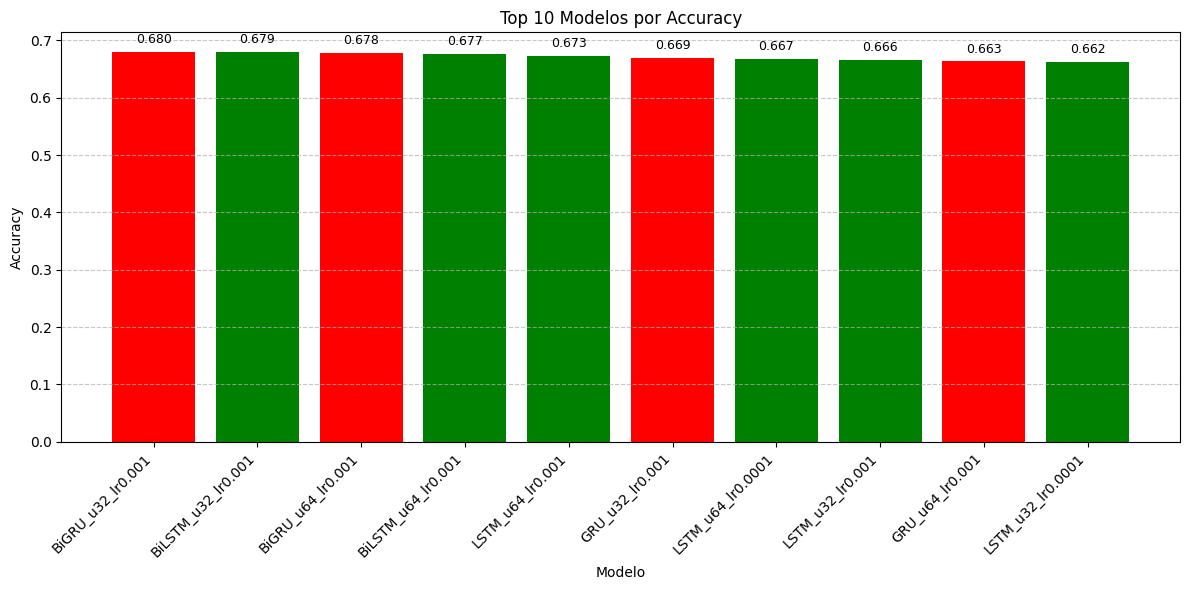

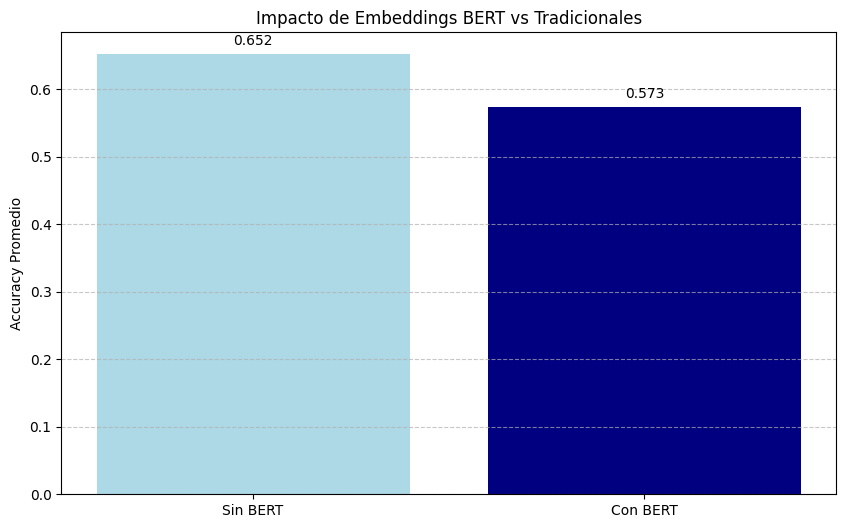

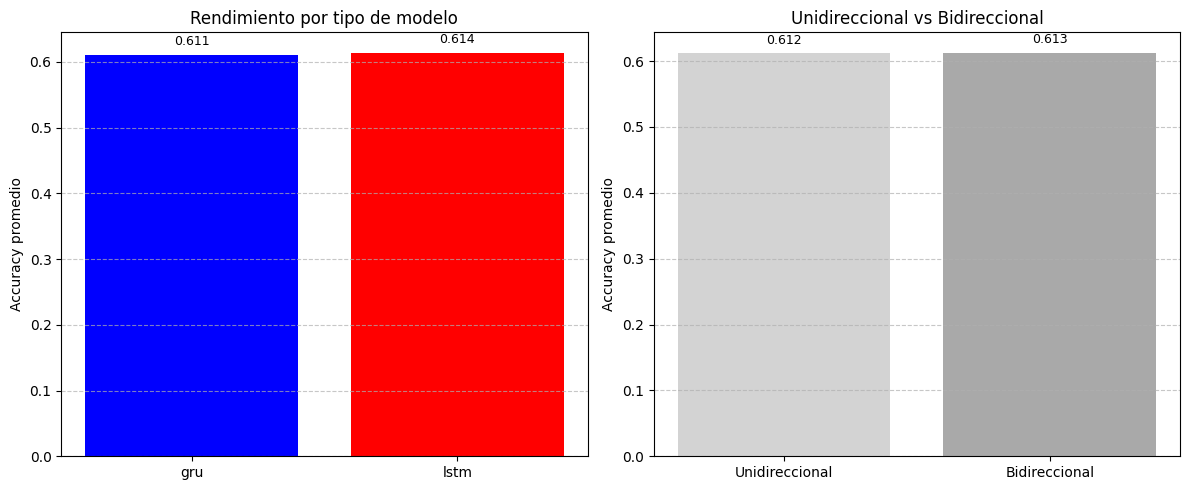


Mejor modelo: BiGRU_u32_lr0.001
Accuracy: 0.6800
F1-Score: 0.6795

Entrenando el mejor modelo con la configuración óptima...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.4488 - loss: 1.0457 - val_accuracy: 0.6695 - val_loss: 0.7682
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.7284 - loss: 0.6622 - val_accuracy: 0.6755 - val_loss: 0.8460
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8774 - loss: 0.3342 - val_accuracy: 0.6740 - val_loss: 1.0227
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9390 - loss: 0.1826 - val_accuracy: 0.6625 - val_loss: 1.1737
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9644 - loss: 0.1078 - val_accuracy: 0.6615 - val_loss: 1.4417
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


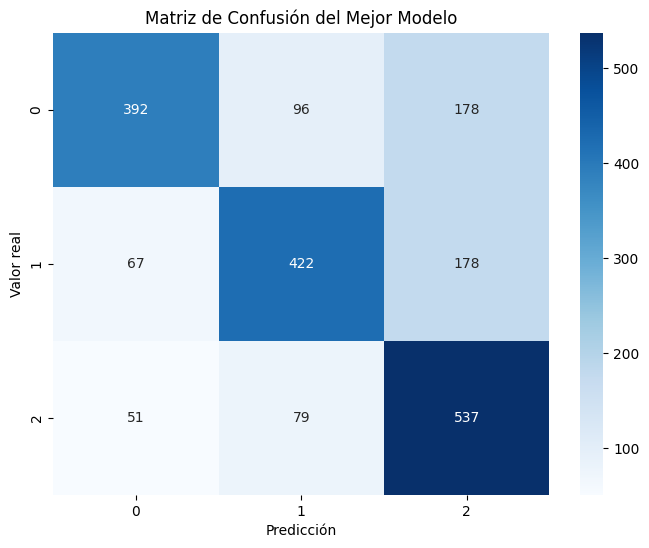


Reporte de clasificación del mejor modelo:
              precision    recall  f1-score   support

           0       0.77      0.59      0.67       666
           1       0.71      0.63      0.67       667
           2       0.60      0.81      0.69       667

    accuracy                           0.68      2000
   macro avg       0.69      0.68      0.67      2000
weighted avg       0.69      0.68      0.67      2000


Mejor modelo guardado como 'best_financial_sentiment_model_gru.keras'


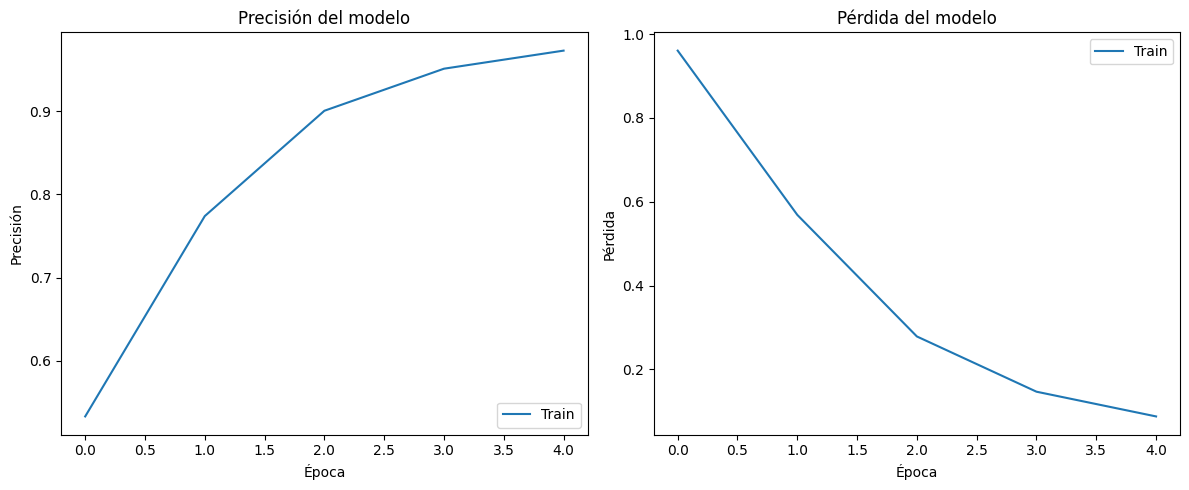


Proceso de grid search y entrenamiento completo.


In [15]:
# VISUALIZACIONES: Comparar rendimiento entre diferentes modelos


# 1. Gráfico de barras para los mejores modelos
plt.figure(figsize=(12, 6))
top_n = min(10, len(all_results_sorted))
top_models = results_df.head(top_n)['model_name'].tolist()
top_accs = results_df.head(top_n)['accuracy'].tolist()

# Colores basados en tipo de modelo
colors = []
for model_type in results_df.head(top_n)['model_type']:
    if model_type == 'simple_rnn':
        colors.append('blue')
    elif model_type == 'lstm':
        colors.append('green')
    else:  # gru
        colors.append('red')

# Gráfico
bars = plt.bar(top_models, top_accs, color=colors)
plt.xlabel('Modelo')
plt.ylabel('Accuracy')
plt.title('Top 10 Modelos por Accuracy')
plt.xticks(rotation=45, ha='right')

# Añadir valores sobre las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 2. Comparar modelos con y sin BERT
plt.figure(figsize=(10, 6))
bert_avg = results_df[results_df['use_bert']]['accuracy'].mean()
no_bert_avg = results_df[~results_df['use_bert']]['accuracy'].mean()

bars = plt.bar(['Sin BERT', 'Con BERT'], [no_bert_avg, bert_avg], color=['lightblue', 'navy'])
plt.ylabel('Accuracy Promedio')
plt.title('Impacto de Embeddings BERT vs Tradicionales')

# Añadir valores sobre las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.3f}', ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 3. Comparación por tipo de modelo y bidireccionalidad
plt.figure(figsize=(12, 5))

# Subgráfico 1: Comparación por tipo de modelo
plt.subplot(1, 2, 1)
model_type_perf = results_df.groupby('model_type')['accuracy'].mean()
bars1 = plt.bar(model_type_perf.index, model_type_perf.values, color=['blue', 'red', 'green'])
plt.title('Rendimiento por tipo de modelo')
plt.ylabel('Accuracy promedio')

# Añadir valores sobre las barras
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.grid(axis='y', linestyle='--', alpha=0.7)

# Subgráfico 2: Comparación bidireccional vs unidireccional
plt.subplot(1, 2, 2)
bidir_perf = results_df.groupby('bidirectional')['accuracy'].mean()
bars2 = plt.bar(['Unidireccional', 'Bidireccional'], bidir_perf.values, color=['lightgray', 'darkgray'])
plt.title('Unidireccional vs Bidireccional')
plt.ylabel('Accuracy promedio')

# Añadir valores sobre las barras
for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Entrenar el mejor modelo con configuración óptima
best_result = all_results_sorted[0]
print(f"\nMejor modelo: {best_result['model_name']}")
print(f"Accuracy: {best_result['accuracy']:.4f}")
print(f"F1-Score: {best_result['f1_score']:.4f}")

# Crear y entrenar el mejor modelo
print("\nEntrenando el mejor modelo con la configuración óptima...")
best_model = create_rnn_model(
    model_type=best_result['model_type'],
    bidirectional=best_result['bidirectional'],
    units=best_result['units'],
    learning_rate=best_result['learning_rate'],
    dropout_rate=0.3,
    use_bert=best_result['use_bert']
)

# Early stopping con un poco más de paciencia para el modelo final
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

# Entrenar modelo final
history = best_model.fit(
    X_train_pad,
    y_train,
    validation_data=(X_test_pad, y_test),
    epochs=10,  # Más épocas para el modelo final
    batch_size=best_result['batch_size'],
    callbacks=[early_stopping],
    verbose=1
)

# Evaluar modelo final
y_pred_probs = best_model.predict(X_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(df['label'].unique()),
            yticklabels=sorted(df['label'].unique()))
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.title('Matriz de Confusión del Mejor Modelo')
plt.show()

# Reporte de clasificación
print("\nReporte de clasificación del mejor modelo:")
print(classification_report(y_test, y_pred))

# Guardar el mejor modelo
model_filename = f'best_financial_sentiment_model_{best_result["model_type"]}.keras'
best_model.save(model_filename)
print(f"\nMejor modelo guardado como '{model_filename}'")

# Graficar el historial de entrenamiento
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Precisión del modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Train'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Pérdida del modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Train'], loc='upper right')

plt.tight_layout()
plt.show()

print("\nProceso de grid search y entrenamiento completo.")